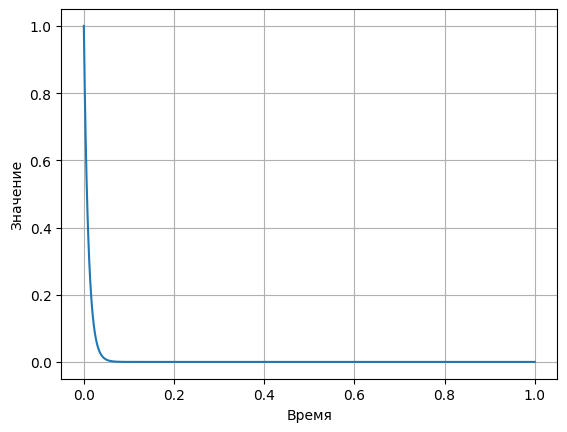

In [13]:
import matplotlib.pyplot as plt
import numpy as np

result = []
epsilon = 0.01

def func(t):
    S = np.exp(- t / epsilon)
    return S

t_values = np.linspace(0, 1, 500)

for t in t_values:
    K = func(t)
    result.append(K)

plt.plot(t_values, result)
plt.xlabel('Время')
plt.ylabel('Значение')
plt.grid(True)
plt.show()




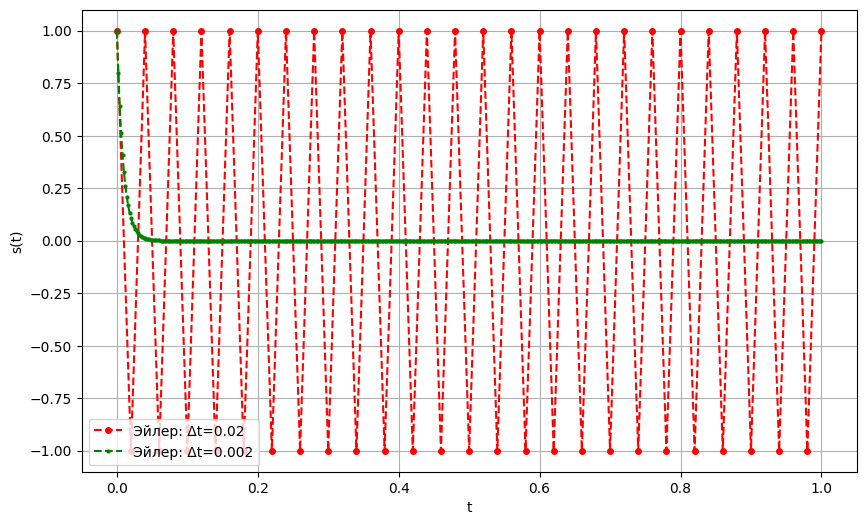

In [14]:
dt_1 = 0.02
dt_2 = 0.002

def Eueler(dt, epsilon):
    t = np.linspace(0, 1, int(1/dt) + 1)
    s = np.zeros(len(t))
    s[0] = 1
    
    for i in range(1, len(t)):
        s[i] = s[i-1] * (1 - dt / epsilon)
    
    return t, s

t1, s1 = Eueler(dt_1, epsilon)  
t2, s2 = Eueler(dt_2, epsilon)  

plt.figure(figsize=(10, 6))
# plt.plot(t_values, result, 'k-', linewidth=2, label='Точное решение')
plt.plot(t1, s1, 'ro--', markersize=4, label=f'Эйлер: Δt={dt_1}')
plt.plot(t2, s2, 'go--', markersize=2, label=f'Эйлер: Δt={dt_2}')
plt.xlabel('t')
plt.ylabel('s(t)')
plt.legend()
plt.grid(True)
plt.show()

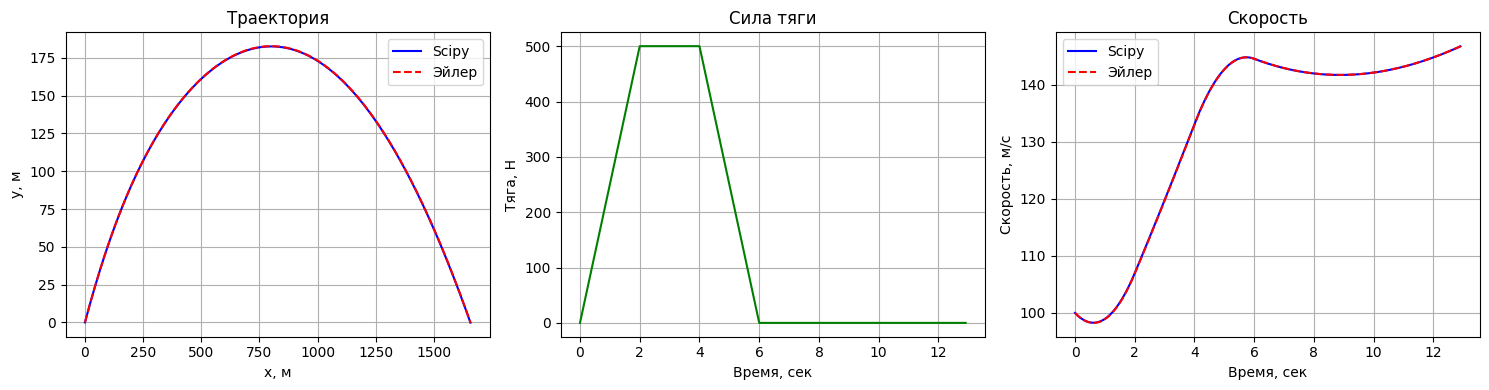

РЕЗУЛЬТАТЫ:
Время полета: 12.9 сек
Дальность: 1657 м
Макс. высота: 183 м


In [15]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.integrate import ode

# Параметры
grad = pi/180 
g = 9.81
ro = 1.240  
a = 340

def C_x(M):
    return 0.44

# Начальные условия
x_0 = 0 
y_0 = 0
V_0 = 100
thetta_0 = 30
mass = 30
S_m = pi*0.1**2/4

Y_0 = np.array([
    x_0, y_0,
    V_0*cos(thetta_0*grad),
    V_0*sin(thetta_0*grad)
])

# Сила тяги
def thrust_profile(t):
    if t < 2: return 250 * t
    elif t < 4: return 500
    elif t < 6: return 500 - 250 * (t - 4)
    else: return 0

# Уравнения движения
def f_with_thrust(t, Y):
    x, y, V_x, V_y = Y
    
    if abs(V_x) < 1e-10:
        thetta = pi/2 if V_y > 0 else -pi/2
    else:
        thetta = atan2(V_y, V_x)
        
    V = sqrt(V_x**2 + V_y**2)
    mach = V/a if V > 0 else 0
    
    F_cx = ro*V**2/2*S_m*C_x(mach)
    mg = mass*g
    F_thrust = thrust_profile(t)
    
    if V > 0:
        a_x = (-F_cx*cos(thetta) + F_thrust*cos(thetta))/mass
        a_y = (-F_cx*sin(thetta) + F_thrust*sin(thetta) - mg)/mass
    else:
        a_x = F_thrust*cos(thetta)/mass
        a_y = F_thrust*sin(thetta)/mass - g
    
    return np.array([V_x, V_y, a_x, a_y])

# Решение scipy
def solve_scipy(y0):
    solver = ode(f_with_thrust)
    solver.set_integrator('dopri5')
    solver.set_initial_value(y0, 0)
    
    t_vals = [0]
    y_vals = [y0]
    
    while solver.successful() and solver.y[1] >= 0:
        solver.integrate(solver.t + 0.01)
        t_vals.append(solver.t)
        y_vals.append(solver.y.copy())
    
    return np.array(t_vals), np.array(y_vals)

# Решение Эйлера
def solve_euler(y0):
    t_vals = [0]
    y_vals = [y0]
    Y = y0
    t = 0
    
    while Y[1] >= 0 and t < 30:
        Y = Y + 0.01 * f_with_thrust(t, Y)
        t += 0.01
        t_vals.append(t)
        y_vals.append(Y)
    
    return np.array(t_vals), np.array(y_vals)

# Расчет
t_scipy, y_scipy = solve_scipy(Y_0)
t_euler, y_euler = solve_euler(Y_0)
thrust = [thrust_profile(t) for t in t_scipy]

# Простые графики
plt.figure(figsize=(15, 4))

# 1. Траектория
plt.subplot(1, 3, 1)
plt.plot(y_scipy[:, 0], y_scipy[:, 1], 'b-', label='Scipy')
plt.plot(y_euler[:, 0], y_euler[:, 1], 'r--', label='Эйлер')
plt.xlabel('x, м')
plt.ylabel('y, м')
plt.title('Траектория')
plt.grid(True)
plt.legend()

# 2. Тяга
plt.subplot(1, 3, 2)
plt.plot(t_scipy, thrust, 'g-')
plt.xlabel('Время, сек')
plt.ylabel('Тяга, Н')
plt.title('Сила тяги')
plt.grid(True)

# 3. Скорость
plt.subplot(1, 3, 3)
V_scipy = np.sqrt(y_scipy[:, 2]**2 + y_scipy[:, 3]**2)
V_euler = np.sqrt(y_euler[:, 2]**2 + y_euler[:, 3]**2)
plt.plot(t_scipy, V_scipy, 'b-', label='Scipy')
plt.plot(t_euler, V_euler, 'r--', label='Эйлер')
plt.xlabel('Время, сек')
plt.ylabel('Скорость, м/с')
plt.title('Скорость')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Простые выводы
print("РЕЗУЛЬТАТЫ:")
print(f"Время полета: {t_scipy[-1]:.1f} сек")
print(f"Дальность: {y_scipy[-1,0]:.0f} м")
print(f"Макс. высота: {np.max(y_scipy[:,1]):.0f} м")